In [1]:
import os
from torchaudio.backend.soundfile_backend import load
from torch.utils.data import Dataset,DataLoader, ConcatDataset
from torchaudio.transforms import MelSpectrogram, Spectrogram
import torch.nn as nn
import torch 
import numpy as np
import gc
from tqdm import tqdm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights, resnet50, ResNet50_Weights,  resnet18, ResNet18_Weights
import torch.nn.functional as F
import math
from torch import flatten
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim import lr_scheduler


In [2]:
params = {'num_classes': 6,
        'batch_size': 4,
        'epochs': 9,
        'win_len': 626, 
        'mel_bins': 128, 
        'hop_len': 313,
        'n_fft' : 626,
        'use_arcface': False, 
        'm': 0.5, 
        's': 30, 
        'sub': 1
       }

In [3]:
"""class AudioDataset(Dataset):
    def __init__(self, params, dev_path, eval_path=None, mel_dev_path=None, mel_eval_path=None, transform=None, sr=16000):
        self.dev_path = dev_path
        self.eval_path = eval_path
        self.mel_dev_path = mel_dev_path
        self.mel_eval_path = mel_eval_path
        self.dev_files = os.listdir(dev_path)
        self.eval_files = os.listdir(eval_path) if eval_path else None
        self.dev_len = len(self.dev_files)
        self.eval_len = len(self.eval_files) if self.eval_files else 0
        self.mel_spectrogram = MelSpectrogram(sample_rate=sr, n_fft=params['n_fft'], hop_length=params['hop_len'], power=2.0)
        self.params = params

    def __len__(self):
        return self.dev_len + self.eval_len

    def __getitem__(self, idx):
        if idx < self.dev_len:
            dataset_path = self.dev_path
            mel_dataset_path = self.mel_dev_path
            files = self.dev_files
        elif 0 < idx - self.dev_len < self.eval_len:
            dataset_path = self.eval_path
            mel_dataset_path = self.mel_eval_path
            files = self.eval_files
            idx -= self.dev_len
        else:
            raise IndexError(f"list index out of range: len={self.dev_len}, eval is not given")
        
        filename = files[idx]
        machine_id = int(filename[11:12])
        label = filename.split('_')[0]
        label = 0 if label == "normal" or label == "id" else 1
        target = nn.functional.one_hot(torch.tensor(machine_id), params["num_classes"])
        audio, sr = load(dataset_path + '/' + filename)
        
        if mel_dataset_path is None:
            mel_spectr = self.mel_spectrogram(audio)
        else:
            mel_spectr = torch.load(mel_dataset_path + '/' + filename[:-4] + '.t')
        
        return audio, mel_spectr, target.float(), torch.FloatTensor([label])"""

'class AudioDataset(Dataset):\n    def __init__(self, params, dev_path, eval_path=None, mel_dev_path=None, mel_eval_path=None, transform=None, sr=16000):\n        self.dev_path = dev_path\n        self.eval_path = eval_path\n        self.mel_dev_path = mel_dev_path\n        self.mel_eval_path = mel_eval_path\n        self.dev_files = os.listdir(dev_path)\n        self.eval_files = os.listdir(eval_path) if eval_path else None\n        self.dev_len = len(self.dev_files)\n        self.eval_len = len(self.eval_files) if self.eval_files else 0\n        self.mel_spectrogram = MelSpectrogram(sample_rate=sr, n_fft=params[\'n_fft\'], hop_length=params[\'hop_len\'], power=2.0)\n        self.params = params\n\n    def __len__(self):\n        return self.dev_len + self.eval_len\n\n    def __getitem__(self, idx):\n        if idx < self.dev_len:\n            dataset_path = self.dev_path\n            mel_dataset_path = self.mel_dev_path\n            files = self.dev_files\n        elif 0 < idx - self

In [4]:
def return_one_hot(label):
    label = int(label)
    t = np.zeros(6)
    t[label] = 1
    return torch.tensor(t).float()

class AudioDataset(Dataset):

    def __init__(self, dir_path, params, transform=None):
        self.dir_path = dir_path
        self.files = os.listdir(dir_path)
        self.transform=transform
        self.params=params

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path=self.dir_path+'/'+self.files[idx]
        machine_id=path.split('/')[-1].split('_')[-2]
        label_path=path.split('/')[-1].split('_')[0]
        
        if label_path == "normal":
            anomaly_label = 1
        elif label_path == "anomaly":
            anomaly_label = 0
        else:
            anomaly_label = 20
            
        audio, sr=load(path)
        
        mel_spectrogram= MelSpectrogram(
                            sample_rate=sr,
                            n_fft=params['n_fft'],
                            hop_length=params['hop_len'],
                            power=2.0
                        )
        
        mel_spectr=mel_spectrogram(audio)

        #spectrogram = Spectrogram(n_fft=446, win_length=446, hop_length=223)
        #spectr=spectrogram(audio)
        
        if self.transform is not None:
            audio=transform(audio)
        
        return audio, mel_spectr, return_one_hot(machine_id), anomaly_label, self.files[idx]

In [5]:
"""class TGramNet(nn.Module):
    def __init__(self, mel_bins,win_len, hop_len, num_layers=3, **kwargs):
        super(TGramNet, self).__init__()
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=mel_bins, kernel_size=win_len, stride=hop_len, padding=win_len // 2, bias=False)
        self.conv_encoder = nn.Sequential(
            *[nn.Sequential(
                nn.LayerNorm(int(160000//hop_len)+1),
                nn.GELU(),
                nn.Conv1d(mel_bins, mel_bins, 3, 1, 1, bias=False)
            ) for _ in range(num_layers)]
        )
        
    def forward(self, x_w):
        x_w = self.conv1d(x_w)
        x_w = self.conv_encoder(x_w)
        return x_w

class STGramNet(nn.Module):
    def __init__(self, params):
        super(STGramNet, self).__init__()
        self.arcface = False
        # self.arcface = ArcMarginProduct(in_features=128, out_features=num_classes, m=m, s=s, sub=sub) if use_arcface else use_arcface
        self.tgramnet = TGramNet(**params)
        # self.classifier = MobileFaceNet(num_class=num_classes, bottleneck_setting=bottleneck_setting)
        #self.classifier = nn.Linear(1001, num_classes)
        self.classifier = convnext_tiny()
        self.classifier.features[0][0] = nn.Conv2d(2, 96, kernel_size=(4, 4), stride=(4, 4))
        self.classifier.classifier[2] = nn.Linear(768, 6)
        self.transform = transforms.Normalize((0.5, 0.5), (0.25, 0.25))
        
        
    def forward(self, x_wav, x_mel, label=None):
        x_t = self.tgramnet(x_wav).unsqueeze(1)
        x = torch.cat((x_mel, x_t), dim=1).to(device)
        x = self.transform(x)
        out = self.classifier(x)
        if self.arcface:
            out = self.arcface(feature, label)
        return out"""

'class TGramNet(nn.Module):\n    def __init__(self, mel_bins,win_len, hop_len, num_layers=3, **kwargs):\n        super(TGramNet, self).__init__()\n        \n        self.conv1d = nn.Conv1d(in_channels=1, out_channels=mel_bins, kernel_size=win_len, stride=hop_len, padding=win_len // 2, bias=False)\n        self.conv_encoder = nn.Sequential(\n            *[nn.Sequential(\n                nn.LayerNorm(int(160000//hop_len)+1),\n                nn.GELU(),\n                nn.Conv1d(mel_bins, mel_bins, 3, 1, 1, bias=False)\n            ) for _ in range(num_layers)]\n        )\n        \n    def forward(self, x_w):\n        x_w = self.conv1d(x_w)\n        x_w = self.conv_encoder(x_w)\n        return x_w\n\nclass STGramNet(nn.Module):\n    def __init__(self, params):\n        super(STGramNet, self).__init__()\n        self.arcface = False\n        # self.arcface = ArcMarginProduct(in_features=128, out_features=num_classes, m=m, s=s, sub=sub) if use_arcface else use_arcface\n        self.tgramn

In [6]:
"""class ArcFace(nn.Module):
    def __init__(self, embed_size, num_classes, scale=64, margin=0.5, easy_margin=False, **kwargs):
        super().__init__()
        self.scale = scale
        self.margin = margin
        self.ce = nn.CrossEntropyLoss()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embed_size))
        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

        nn.init.xavier_uniform_(self.weight)

    def forward(self, embedding: torch.Tensor, ground_truth):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cos_theta = F.linear(F.normalize(embedding), F.normalize(self.weight)).clamp(-1 + 1e-7, 1 - 1e-7)
        sin_theta = torch.sqrt((1.0 - torch.pow(cos_theta, 2)).clamp(-1 + 1e-7, 1 - 1e-7))
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m
        if self.easy_margin:
            phi = torch.where(cos_theta > 0, phi, cos_theta)
        else:
            phi = torch.where(cos_theta > self.th, phi, cos_theta - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cos_theta.size(), device='cuda')
        one_hot.scatter_(1, ground_truth.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
                (1.0 - one_hot) * cos_theta)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.scale

        loss = self.ce(output, ground_truth)
        return loss, output"""

"class ArcFace(nn.Module):\n    def __init__(self, embed_size, num_classes, scale=64, margin=0.5, easy_margin=False, **kwargs):\n        super().__init__()\n        self.scale = scale\n        self.margin = margin\n        self.ce = nn.CrossEntropyLoss()\n        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embed_size))\n        self.easy_margin = easy_margin\n        self.cos_m = math.cos(margin)\n        self.sin_m = math.sin(margin)\n        self.th = math.cos(math.pi - margin)\n        self.mm = math.sin(math.pi - margin) * margin\n\n        nn.init.xavier_uniform_(self.weight)\n\n    def forward(self, embedding: torch.Tensor, ground_truth):\n        # --------------------------- cos(theta) & phi(theta) ---------------------------\n        cos_theta = F.linear(F.normalize(embedding), F.normalize(self.weight)).clamp(-1 + 1e-7, 1 - 1e-7)\n        sin_theta = torch.sqrt((1.0 - torch.pow(cos_theta, 2)).clamp(-1 + 1e-7, 1 - 1e-7))\n        phi = cos_theta * self.cos_m - sin

In [7]:
class TGramNet(nn.Module):
    def __init__(self, mel_bins,win_len, hop_len, num_layers=3, **kwargs):
        super(TGramNet, self).__init__()
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=mel_bins, kernel_size=win_len, stride=hop_len, padding=win_len // 2, bias=False)
        self.conv_encoder = nn.Sequential(
            *[nn.Sequential(
                nn.LayerNorm(int(160000//hop_len)+1),
                nn.GELU(),
                nn.Conv1d(mel_bins, mel_bins, 3, 1, 1, bias=False)
            ) for _ in range(num_layers)]
        )
        
    def forward(self, x_w):
        x_w = self.conv1d(x_w)
        x_w = self.conv_encoder(x_w)
        return x_w

class STGramNet(nn.Module):
    def __init__(self, params):
        super(STGramNet, self).__init__()
        self.arcface = False
        # self.arcface = ArcMarginProduct(in_features=128, out_features=num_classes, m=m, s=s, sub=sub) if use_arcface else use_arcface
        self.tgramnet = TGramNet(**params)
        # self.classifier = MobileFaceNet(num_class=num_classes, bottleneck_setting=bottleneck_setting)
        #self.classifier = nn.Linear(1001, num_classes)
        self.t_resnet=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in self.t_resnet.parameters():
            p.requires_grad = True
        #self.t_resnet.fc=nn.Linear(in_features=2048, out_features=384, bias=True)
        self.t_resnet.fc=nn.Linear(in_features=512, out_features=384, bias=True)
        
        self.s_resnet=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in self.s_resnet.parameters():
            p.requires_grad = True
        #self.s_resnet.fc=nn.Linear(in_features=2048, out_features=384, bias=True)
        self.s_resnet.fc=nn.Linear(in_features=512, out_features=384, bias=True)
        
        self.fc=nn.Sequential(nn.Linear(in_features=768, out_features=70),
                               nn.BatchNorm1d(70),
                               nn.GELU(),
                               nn.Linear(in_features=70, out_features=6))
        
    def forward(self, x_wav, x_mel, label=None):
        x_t = self.tgramnet(x_wav).unsqueeze(1).repeat(1, 3, 1, 1)
        
        x_t = self.t_resnet(x_t)
        x_mel = self.s_resnet(x_mel)
        
        x = torch.cat((x_mel, x_mel), dim=1).to(device) 
        
        out = self.fc(x)
        if self.arcface:
            out = self.arcface(feature, label)
        return out

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# net = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
net = STGramNet(params)
# for p in net.parameters():
#     p.requires_grad = False
# net.classifier[2] = nn.Linear(768, 6)
# net.fc = torch.nn.Linear(net.fc.in_features, 6)

net = net.to(device)
dev_train_path = "/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/train"
dev_test_path = "/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider/test"
eval_train_path = "/kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/train"
eval_test_path = "/kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test"

# mel_dev_train_path = "/kaggle/input/aml2-melspectrograms/MelSpectrogram/dev_train/"
# mel_dev_test_path = "/kaggle/input/aml2-melspectrograms/MelSpectrogram/dev_test/"
# mel_eval_train_path = "/kaggle/input/aml2-melspectrograms/MelSpectrogram/eval_train/"
# mel_eval_test_path = "/kaggle/input/aml2-melspectrograms/MelSpectrogram/eval_test/"    

# dev_train_ds = AudioDataset(params, dev_train_path, eval_path=dev_train_path)
# dev_test_ds = AudioDataset(params, dev_test_path)

dev_train_ds = AudioDataset(dev_train_path, params)
eval_train_ds = AudioDataset(eval_train_path, params)
train_ds = ConcatDataset([dev_train_ds, eval_train_ds])
#train_dl=DataLoader(eval_train_ds, batch_size=params["batch_size"], shuffle=True, num_workers=2)
train_dl = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True, num_workers=2)


dev_test_ds = AudioDataset(dev_train_path, params)
eval_test_ds = AudioDataset(eval_train_path, params)

test_ds = ConcatDataset([dev_test_ds, eval_test_ds])
test_dl = DataLoader(dev_test_ds, batch_size=params["batch_size"], shuffle=True, num_workers=2)

# dev_train_dl = DataLoader(dev_train_ds, batch_size=params["batch_size"], shuffle=True, num_workers=1)
# dev_test_dl = DataLoader(dev_test_ds, batch_size=params["batch_size"], shuffle=True, num_workers=1)

# net = STGramNet(params).to(device)
# net_params = [net_params for net_params in net.parameters() if net_params not in net.resnet.parameters()] + [net.resnet.fc.parameters()]
net_params = [
    {'params': net.tgramnet.parameters()},
    {'params': net.fc.parameters()}
]
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
#criterion = ArcFace(params["batch_size"], 6).to(device)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 243MB/s]


In [9]:
# create spectrogram dataset
# mel_dev_train_path = f"/kaggle/working/mel_dataset/dev_data/train/"
# mel_dev_test_path = f"/kaggle/working/mel_dataset/dev_data/test/"
# mel_eval_train_path = f"/kaggle/working/mel_dataset/eval_data/train/"
# mel_eval_test_path = f"/kaggle/working/mel_dataset/eval_data/test/"

# for d in [mel_dev_train_path, mel_dev_test_path, mel_eval_train_path, mel_eval_test_path]:
    # if not os.path.exists(d):
        # os.makedirs(d)

    # for audio, mel, _, _, idx, filename in tqdm(train_ds):
        # torch.save(mel, f"{d}/{filename[:-4]}.audiomel")

In [10]:
"""device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
for param in net.parameters():
    param.requires_grad = False
net.classifier[2] = nn.Linear(768, 6)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()
net.train()
audio, spectrogram, machine_id, label = next(iter(dev_train_dl))

optimizer.zero_grad()
out = net(spectrogram.to(device))
loss = criterion(out, machine_id.to(device))
# loss.retain_grad()
loss.backward()
# print(loss.grad)
print(list(net.parameters())[0][0])
optimizer.step()
print(list(net.parameters())[0][0])"""

"device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\nnet = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)\nfor param in net.parameters():\n    param.requires_grad = False\nnet.classifier[2] = nn.Linear(768, 6)\nnet = net.to(device)\noptimizer = torch.optim.Adam(net.parameters(), lr=1e-2)\ncriterion = torch.nn.CrossEntropyLoss()\nnet.train()\naudio, spectrogram, machine_id, label = next(iter(dev_train_dl))\n\noptimizer.zero_grad()\nout = net(spectrogram.to(device))\nloss = criterion(out, machine_id.to(device))\n# loss.retain_grad()\nloss.backward()\n# print(loss.grad)\nprint(list(net.parameters())[0][0])\noptimizer.step()\nprint(list(net.parameters())[0][0])"

In [11]:
net.train()
l = []
for e in range(params["epochs"]):
    print(f"epoch {e+1}th")
    epoch_loss = []
    for audio, spectrogram, machine_id, _, filename in tqdm(train_dl, total=len(train_dl)):
        optimizer.zero_grad()
        output = net(audio.to(device), spectrogram.to(device).repeat(1, 3, 1, 1))
        loss = criterion(output, machine_id.to(device))
#         output.retain_grad()
        loss.backward()
        # print(output.grad.mean())
#         fc_grad = net.resnet.fc.grad.copy()
#         net.resnet.grad = torch.zeros_like(net.resnet.grad).to(device).float()
#         net.resnet.fc.grad = fc_grad
        optimizer.step()
        epoch_loss.append(loss.item())
    l.append(np.array(epoch_loss).mean())
    print(np.array(epoch_loss).mean())
        # break
print('done')

epoch 1th


100%|██████████| 1185/1185 [00:56<00:00, 21.04it/s]


1.1528166738492025
epoch 2th


100%|██████████| 1185/1185 [00:41<00:00, 28.55it/s]


0.5575147025821581
epoch 3th


100%|██████████| 1185/1185 [00:41<00:00, 28.44it/s]


0.3618765070720061
epoch 4th


100%|██████████| 1185/1185 [00:42<00:00, 27.73it/s]


0.282857549225102
epoch 5th


100%|██████████| 1185/1185 [00:43<00:00, 27.42it/s]


0.24531535553561232
epoch 6th


100%|██████████| 1185/1185 [00:41<00:00, 28.54it/s]


0.18476859333881723
epoch 7th


100%|██████████| 1185/1185 [00:41<00:00, 28.41it/s]


0.18392968223821216
epoch 8th


100%|██████████| 1185/1185 [00:40<00:00, 29.48it/s]


0.14646023504862382
epoch 9th


100%|██████████| 1185/1185 [00:42<00:00, 28.03it/s]

0.1338337997517368
done


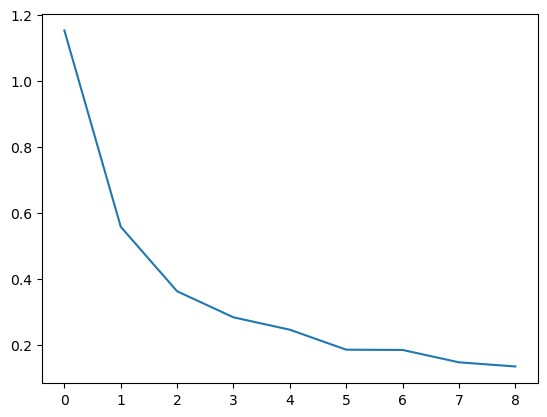

In [12]:
plt.plot(l)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
eval_test_ds = AudioDataset(eval_test_path, params)
#eval_test_ds = AudioDataset(eval_test_path, params)

# test_ds = ConcatDataset([dev_test_ds, eval_test_ds])
test_dl = DataLoader(eval_test_ds, batch_size=32, shuffle=False)
names = []
scores = []
y_true = []
y_pred = []
net.eval()
with torch.no_grad():
    for i, (audio, spectrogram, machine_id, label, filename) in tqdm(enumerate(test_dl), total=len(test_dl)):
        output = net.forward(audio.to(device), spectrogram.to(device).repeat(1, 3, 1, 1))
        softmax = output.softmax(dim=1)
        score = softmax[:, machine_id.to(device).argmax(dim=1)].diag()
        prob = 1 - score
        y_true.extend(label)
        y_pred.extend(score.cpu().numpy())
        names.extend(filename)
        scores.extend(prob.cpu().detach().numpy())
    
submission_df = pd.DataFrame(names, columns=["file_name"])
submission_df["anomaly_score"] = scores
submission_df.to_csv("/kaggle/working/sample_submission.csv", index=False)
